<a href="https://colab.research.google.com/github/javst42/COVID-19-Datathon/blob/master/SB_LIGHTGBM_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

In [0]:
plt.style.use('seaborn')

In [0]:
%load_ext google.colab.data_table

# Patient level data survival


In [0]:
# latest data from: https://github.com/beoutbreakprepared/nCoV2019/tree/master/latest_data
df_ncov19 = pd.read_csv('https://brunods10.s3-us-west-2.amazonaws.com/MIT_COVID/latestdata.csv')
df_ncov19.info()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658380 entries, 0 to 658379
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        658380 non-null  object 
 1   age                       18646 non-null   object 
 2   sex                       17330 non-null   object 
 3   city                      504368 non-null  object 
 4   province                  631896 non-null  object 
 5   country                   658277 non-null  object 
 6   latitude                  658330 non-null  float64
 7   longitude                 658330 non-null  float64
 8   geo_resolution            658330 non-null  object 
 9   date_onset_symptoms       4349 non-null    object 
 10  date_admission_hospital   1867 non-null    object 
 11  date_confirmation         655520 non-null  object 
 12  symptoms                  3205 non-null    object 
 13  lives_in_Wuhan            4290 non-null    o

In [0]:
df_ncov19.shape

(658380, 33)

In [0]:
df_ncov19.isna().sum(axis = 0)*100.00/df_ncov19.shape[0]

ID                           0.000000
age                         97.167897
sex                         97.367782
city                        23.392570
province                     4.022601
country                      0.015644
latitude                     0.007594
longitude                    0.007594
geo_resolution               0.007594
date_onset_symptoms         99.339439
date_admission_hospital     99.716425
date_confirmation            0.434400
symptoms                    99.513199
lives_in_Wuhan              99.348401
travel_history_dates        99.656733
travel_history_location     99.130138
reported_market_exposure    99.799508
additional_information      98.496765
chronic_disease_binary       0.000000
chronic_disease             99.967800
source                       3.406847
sequence_available          99.796318
outcome                     99.572587
date_death_or_discharge     99.922993
notes_for_discussion        99.713084
location                    98.847930
admin3      

In [0]:
import seaborn as sns 
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 9

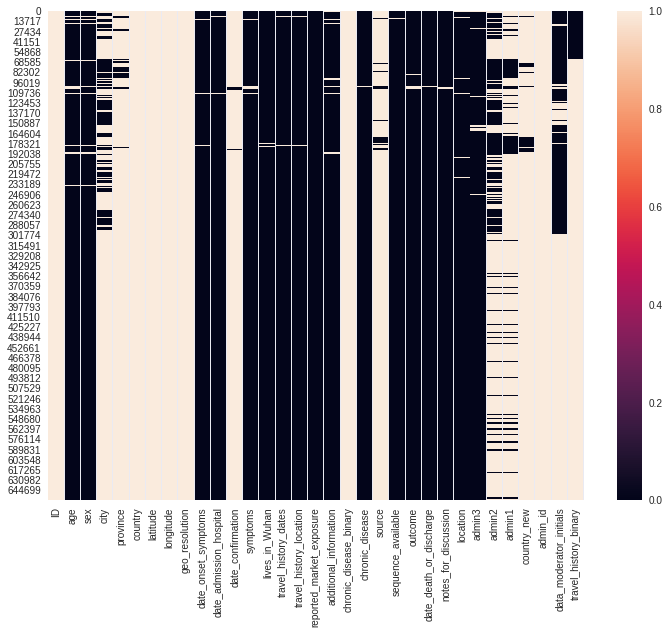

In [0]:
sns.heatmap(~df_ncov19.isnull(), cbar=True)

In [0]:
df_ncov19[~df_ncov19['date_admission_hospital'].isna()]['country'].value_counts()

# df_ncov19[~df_ncov19['date_death_or_discharge'].isna()]['ID'].count()

China                   1123
Singapore                275
Japan                    124
South Korea               54
Brazil                    36
Australia                 32
United States             30
Canada                    30
Vietnam                   18
Philippines               16
Thailand                  12
France                     9
Algeria                    9
United Arab Emirates       8
Malaysia                   6
Germany                    5
Romania                    5
Nigeria                    4
United Kingdom             4
Italy                      3
Namibia                    3
Malta                      2
Bahrain                    2
Pakistan                   2
Iraq                       2
Bolivia                    2
Guatemala                  2
Nepal                      2
Kazakhstan                 2
Cambodia                   2
Sri Lanka                  2
Bhutan                     2
Ukraine                    2
Switzerland                1
Lithuania     

In [0]:
df_ncov19['date_admission_hospital'].unique()

array([nan, '04.02.2020', '30.01.2020', '14.02.2020', '17.02.2020',
       '13.02.2020', '10.02.2020', '12.02.2020', '15.02.2020',
       '08.02.2020', '05.02.2020', '07.02.2020', '09.02.2020',
       '26.01.2020', '26.02.2020', '03.02.2020', '28.01.2020',
       '06.02.2020', '11.02.2020', '16.02.2020', '19.02.2020',
       '22.01.2020', '18.01.2020', '23.01.2020', '20.02.2020',
       '18.02.2020', '21.02.2020', '24.01.2020', '22.02.2020',
       '29.01.2020', '27.01.2020', '23.02.2020', '24.02.2020',
       '25.02.2020', '25.01.2020', '27.02.2020', '08.01.2020',
       '15.01.2020', '17.01.2020', '28.02.2020', '20.01.2020',
       '01.03.2020', '10.01.2020', '29.03.2020', '29.02.2020',
       '13.01.2020', '03.01.2020', '04.03.2020', '03.03.2020',
       '05.03.2020', '02.03.2020', '03.04.2020', '06.03.2020',
       '31.01.2020', '08.03.2020', '09.03.2020', '10.03.2020',
       '07.03.2020', '01.02.2020', '02.02.2020', '14.01.2020',
       '21.01.2020', '13.03.2020', '19.01.2020', '

In [0]:
# df_ncov19[['ID', 'age']].groupby('age').count()

df_ncov19 = df_ncov19[~df_ncov19['age'].str.contains('|'.join(['-', 'weeks', 'month']), na=False)]

df_ncov19['age']

0         NaN
1          78
2          61
3         NaN
4         NaN
         ... 
658375    NaN
658376    NaN
658377    NaN
658378    NaN
658379    NaN
Name: age, Length: 654787, dtype: object

In [0]:
!pip install pycountry-convert


In [0]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code,  cn_continent)

df_ncov19['continent'] = df_ncov19['country'].apply(get_continent)  


0         NaN
1          78
2          61
3         NaN
4         NaN
         ... 
658375    NaN
658376    NaN
658377    NaN
658378    NaN
658379    NaN
Name: age, Length: 654787, dtype: object

In [0]:
df_ncov19.groupby('country')['ID'].count()

country
Afghanistan                              8
Algeria                               1267
Andhra Pradesh                          59
Andorra                                  1
Angola                                   4
Argentina                             1137
Armenia                                  2
Australia                              320
Austria                               4240
Azerbaijan                               6
Bahamas                                 88
Bahrain                                 68
Belgium                               3746
Benin                                    5
Bhutan                                   2
Bolivia                                 81
Bosnia and Herzegovina                   2
Brazil                                4120
Bulgaria                                 4
Burkina Faso                           211
Cabo Verde                               4
Cambodia                                 2
Cameroon                                93
Can

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


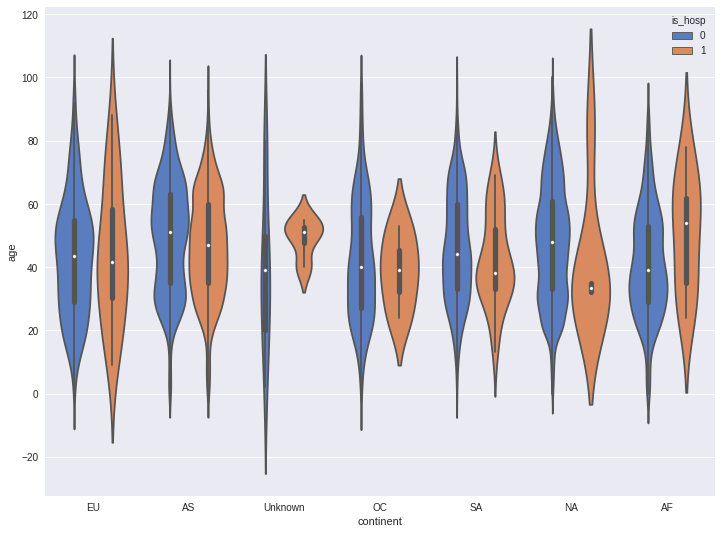

In [0]:
import math 

df_hosp = df_ncov19[['continent', 'date_admission_hospital', 'age']]

df_hosp['age'] = df_hosp['age'].astype('float')

df_hosp = df_hosp[df_hosp['age'] <= 100]

df_hosp['is_hosp'] = df_hosp['date_admission_hospital'].apply(lambda x: 0 if pd.isnull(x) else 1)

df_hosp.head()
 
ax = sns.violinplot(x="continent", y="age", hue="is_hosp", data=df_hosp, palette="muted")


In [0]:
df_hosp = df_ncov19[['continent', 'date_admission_hospital', 'age']]

df_hosp['age'] = df_hosp['age'].astype('float')

df_hosp = df_hosp[df_hosp['age'] <= 100]

df_hosp['is_hosp'] = df_hosp['date_admission_hospital'].apply(lambda x: 0 if pd.isnull(x) else 1)

df_hosp.head()
 
ax = sns.violinplot(x="continent", y="age", hue="is_hosp", data=df_hosp, palette="muted")


In [0]:
df_ncov19.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary,continent
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,mainland via the Lok Ma Chau border crossing,NaN,Case 55;,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8051.0,NaN,NaN,AS
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8978.0,NaN,NaN,EU
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,201.0,NaN,NaN,AS
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10115.0,NaN,NaN,AS
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7079.0,NaN,NaN,AS


In [0]:
df_ncov20 = pd.read_csv('https://brunods10.s3-us-west-2.amazonaws.com/MIT_COVID/survival_master_dummy.csv', low_memory=False)

In [0]:
df_ncov20.head()

,id,sex,age,country,symptoms,outcome,latitude,longitude,date_onset_symptoms,date_admission_hospital,date_death_or_discharge,date_confirmation,date_start,continent,fever,systemic,pneumonia,respiratory,cough,pharyngitis,dyspnea,other_unspecified,unspecified,malaise,other_gastrointestinal,gastrointestinal,other_systemic,fatigue,nausea,other_respiratory,rhinorrhea,other_muscoluskeletal,musculoskeletal,other_neurological,neurological,asthenia,myalgia,other_musculoskeletal,other_ocular,ocular,ILI,emesis,pain,other_muscoloskeletal,ARDS,sepsis,other_cardiovascular,cardiovascular,AKD,renal,organ failure,MI,days_to_event,dead,hospitalized
0,000-1-1,male,NaN,China,NaN,"critical condition, intubated as of 14.02.2020",22.365019,114.133808,NaN,NaN,NaN,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,0,0
1,000-1-10,male,78.0,Italy,NaN,death,45.297748,11.658382,NaN,NaN,2020-02-22,2020-02-21,2020-02-21,Europe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,000-1-100,female,61.0,Singapore,NaN,discharge,1.353460,103.815100,NaN,NaN,2020-02-17,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
3,000-1-1000,NaN,NaN,China,NaN,NaN,34.629310,113.468000,NaN,NaN,NaN,2020-01-26,2020-01-26,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,106,0,0
4,000-1-10000,NaN,NaN,China,NaN,NaN,27.513560,113.902900,NaN,NaN,NaN,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,0,0


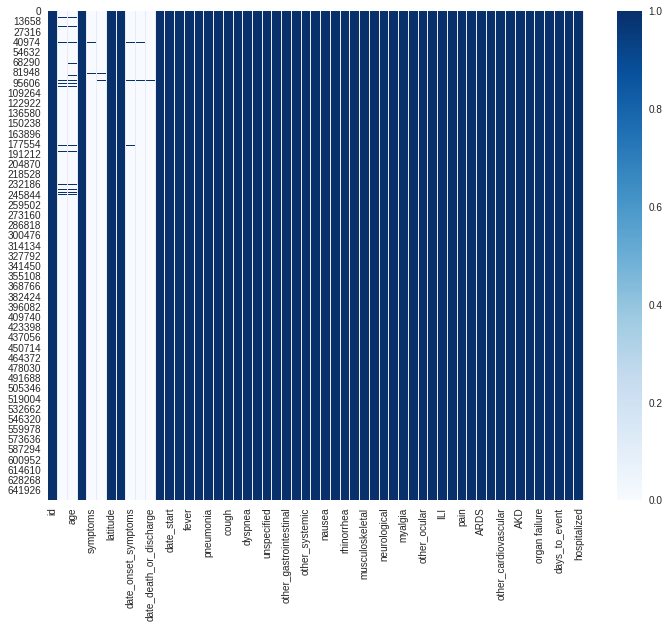

In [0]:
sns.heatmap(~df_ncov20.isnull(), cmap = 'Blues')

In [0]:
df_ncov20[df_ncov20['date_admission_hospital'].isna()]['id'].count()/df_ncov20.shape[0]

0.9971627354281295

In [0]:
mask = ~df_ncov20['sex'].isna() & ~df_ncov20['age'].isna() & ~df_ncov20['date_death_or_discharge'].isna()

df_ncov20 = df_ncov20[mask]

df_ncov20.shape

(396, 55)

In [0]:
df_ncov20.head()

,id,sex,age,country,symptoms,outcome,latitude,longitude,date_onset_symptoms,date_admission_hospital,date_death_or_discharge,date_confirmation,date_start,continent,fever,systemic,pneumonia,respiratory,cough,pharyngitis,dyspnea,other_unspecified,unspecified,malaise,other_gastrointestinal,gastrointestinal,other_systemic,fatigue,nausea,other_respiratory,rhinorrhea,other_muscoluskeletal,musculoskeletal,other_neurological,neurological,asthenia,myalgia,other_musculoskeletal,other_ocular,ocular,ILI,emesis,pain,other_muscoloskeletal,ARDS,sepsis,other_cardiovascular,cardiovascular,AKD,renal,organ failure,MI,days_to_event,dead,hospitalized
1,000-1-10,male,78.0,Italy,NaN,death,45.297748,11.658382,NaN,NaN,2020-02-22,2020-02-21,2020-02-21,Europe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,000-1-100,female,61.0,Singapore,NaN,discharge,1.353460,103.815100,NaN,NaN,2020-02-17,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
113,000-1-101,male,28.0,Singapore,NaN,discharge,1.353460,103.815100,NaN,NaN,2020-02-20,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0
224,000-1-102,female,56.0,Singapore,NaN,discharge,1.353460,103.815100,NaN,NaN,2020-03-02,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0
335,000-1-103,female,79.0,Singapore,NaN,discharge,1.353873,103.860478,2020-01-30,NaN,2020-02-29,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0


Clustering with TSNE

In [0]:
from sklearn.manifold import TSNE

In [0]:
df_ncov20_copy = df_ncov20.copy()

df_ncov20_copy['sex'].apply(lambda x: temp[x])

sex
female    0.383838
male      0.616162
Name: id, dtype: float64

In [0]:
df_ncov20_copy = df_ncov20.copy()

def process_outcome(outcome):

  if type(outcome) == str:

      if outcome.lower() in ['dead', 'death', 'died', 'Deceased']:

        return 'died'
      
      elif outcome.lower() in ['discharged', 'discharge']:
          
          return 'discharged'

      elif outcome.lower() in ['recovered']:

          return 'recovered'
    
      elif outcome.lower() in ['released from quarantine']:

          return 'released'
      
      else: 
          return 'UNK'
    
  else: 

        return 'UNK'


df_ncov20_copy['outcome'] = df_ncov20_copy['outcome'].apply(process_outcome)


In [0]:
%%time

# df_ncov20_copy = df_ncov20.copy()

## Frequency Encoding Categrical features

cols_encoding = ['sex', 'age', 'country', 'outcome']

for col in cols_encoding:

  print('Encoding Col: {}'.format(col))

  temp = df_ncov20_copy.groupby(col)['id'].count()/df_ncov20_copy.shape[0]
  
  df_ncov20_copy[col] = df_ncov20_copy[col].apply(lambda x: temp[x])

df_ncov20_copy.head()


Encoding Col: sex
Encoding Col: age
Encoding Col: country
Encoding Col: outcome
CPU times: user 33.2 ms, sys: 1.09 ms, total: 34.3 ms
Wall time: 34 ms


In [0]:
X_tsne = df_ncov20_copy.drop(['id', 'dead', 'continent', 'symptoms', 'date_death_or_discharge', 'date_confirmation', 'date_start', 'date_onset_symptoms', 'date_admission_hospital'], axis = 1)

y_tsne = df_ncov20_copy['dead']

X_tsne_fitted = TSNE(perplexity = 20, early_exaggeration = 12, learning_rate = 500, n_iter = 500).fit_transform(X_tsne)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


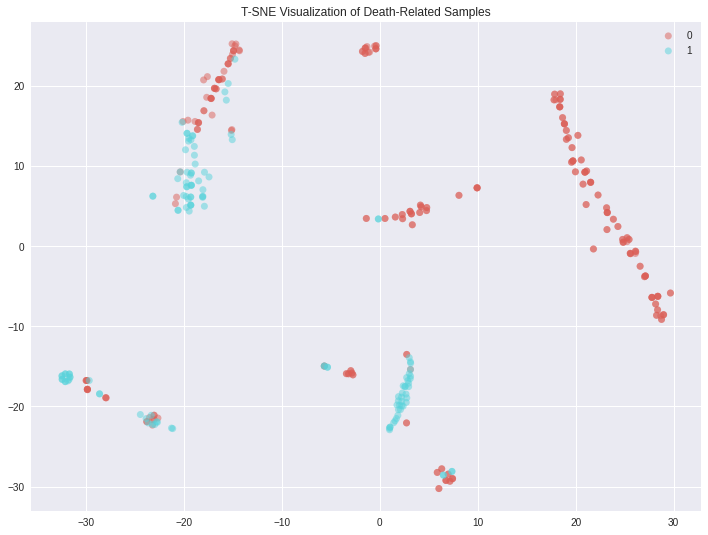

In [0]:
palette = np.array(sns.color_palette("hls", len(np.unique(y_tsne))))

for idx, label in enumerate(np.unique(y_tsne)):

    plt.scatter(x = X_tsne_fitted[y_tsne==label,0], y = X_tsne_fitted[y_tsne==label,1], c = palette[idx], label= label ,
               
               alpha=0.5, edgecolors='none')

plt.legend()

plt.title('T-SNE Visualization of Death-Related Samples')

plt.show()

LightGBM Regressor

In [0]:
# !pip install lightgbm

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold

from math import sqrt

In [0]:
def rmse(y, y_hat):

  return sqrt(np.mean((y - y_hat)**2))


In [0]:
df_ncov20_copy.head()

,id,sex,age,country,symptoms,outcome,latitude,longitude,date_onset_symptoms,date_admission_hospital,date_death_or_discharge,date_confirmation,date_start,continent,fever,systemic,pneumonia,respiratory,cough,pharyngitis,dyspnea,other_unspecified,unspecified,malaise,other_gastrointestinal,gastrointestinal,other_systemic,fatigue,nausea,other_respiratory,rhinorrhea,other_muscoluskeletal,musculoskeletal,other_neurological,neurological,asthenia,myalgia,other_musculoskeletal,other_ocular,ocular,ILI,emesis,pain,other_muscoloskeletal,ARDS,sepsis,other_cardiovascular,cardiovascular,AKD,renal,organ failure,MI,days_to_event,dead,hospitalized
1,000-1-10,0.616162,0.012626,0.010101,NaN,0.313131,45.297748,11.658382,NaN,NaN,2020-02-22,2020-02-21,2020-02-21,Europe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,000-1-100,0.383838,0.017677,0.282828,NaN,0.515152,1.353460,103.815100,NaN,NaN,2020-02-17,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
113,000-1-101,0.616162,0.020202,0.282828,NaN,0.515152,1.353460,103.815100,NaN,NaN,2020-02-20,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0
224,000-1-102,0.383838,0.027778,0.282828,NaN,0.515152,1.353460,103.815100,NaN,NaN,2020-03-02,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0
335,000-1-103,0.383838,0.017677,0.282828,NaN,0.515152,1.353873,103.860478,2020-01-30,NaN,2020-02-29,2020-02-14,2020-02-14,Asia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0


In [0]:

lgb_model = lgb.LGBMRegressor(max_depth = -1, n_estimators = 1000, silent = False)

df_ncov20_mod = df_ncov20_copy.drop(['id', 'dead', 'outcome', 'symptoms', 'continent', 'date_start', 'date_onset_symptoms', 'date_admission_hospital', 'date_death_or_discharge', 'date_confirmation'], axis =1)

y = df_ncov20_mod['days_to_event']

X = df_ncov20_mod.drop(['days_to_event'], axis =1)

strat = StratifiedKFold(n_splits=5)

scores = []

for train_idx, test_idx in strat.split(X, y):

  X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

  y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

  lgb_model.fit(X_train, y_train)

  preds = lgb_model.predict(X_test)

  print(rmse(preds, y_test))

scores

The least populated class in y has only 1 members, which is less than n_splits=5.


4.6227545463524455
5.7967048543067055
6.3188289289753925
4.5126307507018595
4.692375254148677


[]

In [0]:
# print the JS visualization code to the notebook
!pip install shap 
import shap 
shap.initjs()



     |████████████████████████████████| 276kB 7.2MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394118 sha256=bb7cde3683418efa939fb62b457c36d05b1403f76e1b52480eab3d2300d5db34
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


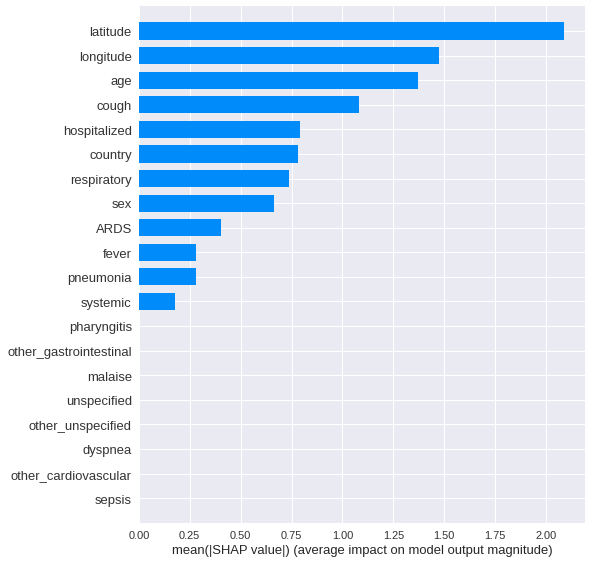

In [0]:
explainer = shap.TreeExplainer(lgb_model)

shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

shap.summary_plot(shap_values, X, plot_type="bar")


In [0]:
import re 

list_symptoms = df_ncov19['symptoms'].unique()

list_symptoms = list_symptoms[1:].tolist()

list_symptoms = [x for x in list_symptoms if  not x in ['02/02/20', \
'03/02/20', '17/03/20', '21/03/20', '24/03/20', '28/03/20', \
       '02/04/20', '03/04/20', '04/04/20', '05/04/20', '06/04/20', \
       '08/04/20', '15/04/20', '16/04/20']]

symptoms_list = []

for ll in list_symptoms:

   splitted_symtoms = re.split(', | : ', ll)

   for k in splitted_symtoms :

         symptoms_list.append(k)
      
symptoms_list = set(symptoms_list)

symptoms_list

{'Asymptomatic',
 'COVID-19 related symptoms',
 'Contact of hCoV-19/Brazil/SPBR-01/2020',
 'Fever',
 'Mild resipiratory symptoms',
 'Mild respiratory symptoms',
 'Mild to moderate',
 'Mild:moderate',
 'Pharyngeal dryness',
 'Pnuemonia',
 'Rhinorrhea',
 'Severe',
 'Sore throat',
 'Symptoms associated with a respiratory condition',
 'abdominal pain',
 'aching muscles',
 'acute coronary syndrome:congestive heart failure:severe acute respiratory infection',
 'acute kidney injury',
 'acute kidney injury:septic shock:acute respiratory distress syndrome',
 'acute myocardial infarction',
 'acute pharyngitis',
 'acute respiratory disease',
 'acute respiratory distress syndrome',
 'acute respiratory distress syndrome:pneumonia',
 'acute respiratory distress syndrome:pneumonia:acute respiratory failure',
 'acute respiratory distress syndrome:pneumonia:hypoxia',
 'acute respiratory distress syndrome:pneumonia:septic shock',
 'acute respiratory distress syndrome:septic shock',
 'acute respiratory d